### Importing Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/utk.tennessee.edu/nnaraya2/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
%load_ext autoreload
%autoreload 1
%aimport twitter_disaster_classification

In [3]:
training_data = pd.read_csv('train.csv', index_col='id')
print('The shape of the training data is ', training_data.shape)
training_data.head(3)

The shape of the training data is  (7613, 4)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
training_data.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [5]:
# We set the id to be index because it is unique
training_data.index.is_unique

True

**Target 1 means it is 'Disaster related' and 0 means 'not'**

### Descriptive Statistics

In [6]:
print('The total number of disaster related tweets in the training data are',training_data[training_data.target == 1].shape)

print('The total number of non-disaster related tweets in the training data are',training_data[training_data.target == 0].shape)

The total number of disaster related tweets in the training data are (3271, 4)
The total number of non-disaster related tweets in the training data are (4342, 4)


In [7]:
# Lets check how many null values are there in each of the columns
training_data.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

**From the above analysis , we can see that the keyword contains 61 NaN values. What exactly is a keyword.**

**It is a word in the tweet which is a biggest hint to classify the tweet to its proper bin.**

**Lets take a look at the keywords**

In [8]:
keyword_list = list(training_data.keyword.value_counts().index)
print('The total number of unique keywords in the dataset is ', len(keyword_list))

The total number of unique keywords in the dataset is  221


**Out of all the 221 keywords, some are disaster related and some are not. 
Some might overlap. So we will split the disaster related keywords and non disaster related keywords.
We will also check for any keyword which appears in both the category**

In [9]:
def keyword_for_category(data, categorical_column):
    total_categories = list(data[categorical_column].unique())
    category_keywords = {}
    for category in total_categories:
        temp_data = data[data[categorical_column] == category]
        temp_data = temp_data[~temp_data.keyword.isna()]
        category_keywords[category] = list(temp_data.keyword.unique())
    return category_keywords

keyword_list = keyword_for_category(training_data,'target')

print('The length of the keyword list for target 0 is ',len(keyword_list[0]))
print('The length of the keyword list for target 1 is ',len(keyword_list[1]))


The length of the keyword list for target 0 is  218
The length of the keyword list for target 1 is  220


In [10]:
count = 0
for keyword in keyword_list[0]:
    if keyword in keyword_list[1]:
        # print(f'This keyword {keyword} is present in both the list')
        count += 1
print('The total number of keywords which appear in both the categories are', count)

The total number of keywords which appear in both the categories are 217


**The number of overlapping keywords in both the categories are 217. 
The total number of unique keywords in data for target 0 is 218 and the total number of unique keywords in data for target 1 is 220.**

**From the above analysis, we can see that the same keywords are present in both the target text.
So even if we know the keyword, it does not help in identifying the disaster.**

\
\
**Now to run any model, we need features. We will now do feature extraction.**

In [11]:
i = np.random.randint(low = 0, high = training_data.shape[0])
print('i = ',i)
print('the keyword for this observation is ',training_data.keyword.iloc[i])
print('the target for this observatiob is ', training_data.target.iloc[i])
training_data.text.iloc[i]

i =  2209
the keyword for this observation is  deluge
the target for this observatiob is  0


'WA smiles after July deluge - The West Australian https://t.co/4Yi4nuovbV via @Yahoo7'

In [12]:
training_data['length_of_tweet'] = training_data['text'].map(lambda x: len(x.split(' ')))
training_data['length_of_tweet']

id
1        13
4         7
5        22
6         9
7        17
         ..
10869    11
10870    20
10871     8
10872    19
10873    13
Name: length_of_tweet, Length: 7613, dtype: int64

Text(0.5, 1.0, 'Histogram of length of tweets')

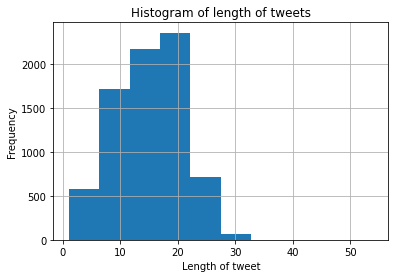

In [13]:
training_data['length_of_tweet'].hist()
plt.xlabel('Length of tweet')
plt.ylabel('Frequency')
plt.title('Histogram of length of tweets')
# plt.savefig('hist_length_of_complete_tweets.png')

Text(0.5, 1.0, 'Histogram of length of tweets for Target 1')

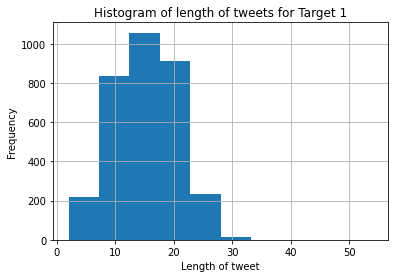

In [14]:
training_data[training_data['target'] == 1].length_of_tweet.hist()
plt.xlabel('Length of tweet')
plt.ylabel('Frequency')
plt.title('Histogram of length of tweets for Target 1')
# plt.savefig('hist_length_of_complete_tweets_target_1.png')

Text(0.5, 1.0, 'Histogram of length of tweets for Target 0')

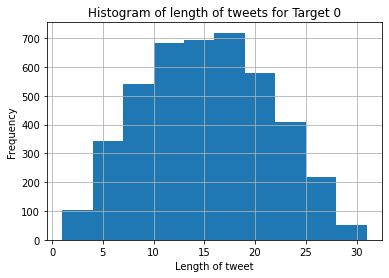

In [15]:
training_data[training_data['target'] == 0].length_of_tweet.hist()

plt.xlabel('Length of tweet')
plt.ylabel('Frequency')
plt.title('Histogram of length of tweets for Target 0')
# plt.savefig('hist_length_of_complete_tweets_target_0.png')

In [16]:
training_data.drop(['keyword','location','length_of_tweet'],axis =1, inplace = True)
training_data

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
10869,Two giant cranes holding a bridge collapse int...,1
10870,@aria_ahrary @TheTawniest The out of control w...,1
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


### Spacy's embedding model

**Create embeddings using spacy**

In [17]:
nlp = spacy.load('en_core_web_lg')

# Function to generate embeddings
def get_embeddings(text):
    return nlp(text).vector

# Apply the function to your text data
training_data['embeddings'] = training_data['text'].apply(get_embeddings)

# Convert embeddings to DataFrame
embedding_data = pd.DataFrame(training_data['embeddings'].tolist(), index=training_data.index)

# Add prefix to column names and save the changes
embedding_data = embedding_data.add_prefix('col_')

# Concatenate the original data with the embeddings
training_data = pd.concat([training_data, embedding_data], axis=1)

# Drop the 'embeddings' column
training_data.drop(['text','embeddings'], axis=1, inplace=True)

# Display the DataFrame
training_data


,target,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299
id,,,,,,,,,,,,,,,,,,,,,
1,1,-0.965633,0.086769,-2.250724,0.478379,3.532167,-0.247309,0.392153,1.925156,-0.701914,...,1.683207,-0.021486,1.106440,0.431469,-0.313029,-0.021668,0.581316,-2.809032,-1.712710,1.061859
4,1,-1.868164,-1.616524,-0.216090,-1.765224,5.974267,1.922159,0.690725,0.069881,2.742931,...,-1.195310,0.613303,2.900191,2.607584,-0.936022,-0.535041,1.210110,-1.383270,0.441298,-0.050350
5,1,-2.407037,0.270426,-1.363999,0.701367,3.675223,1.582620,-0.644550,1.742566,0.174271,...,1.187139,-2.308610,0.014815,-0.684907,-1.867207,0.122962,-0.973975,-3.396315,-2.185061,2.866020
6,1,-1.025510,-0.151214,-2.233153,1.724021,2.796893,1.858077,0.964904,2.631326,1.567343,...,2.059174,1.094201,-1.069009,0.610444,-1.042482,1.537349,0.679432,-2.311998,-0.967111,1.274361
7,1,0.085178,-0.106728,-1.918552,0.144816,3.293158,0.061573,1.477297,2.466106,0.537074,...,-0.885902,1.174743,0.604590,0.658647,0.150191,2.117728,0.906928,-0.349734,-1.480108,0.089182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,1,-2.091437,0.171194,-2.585682,0.930478,2.685859,1.078514,0.078895,3.983783,1.651738,...,-1.741785,-0.410443,0.212764,1.817382,-0.570596,1.530748,0.067114,-0.759120,-0.697182,0.012959
10870,1,-2.895000,-0.473240,-1.532038,1.389379,6.497432,1.450311,0.391119,4.103290,2.302696,...,0.198556,0.964475,0.619170,0.890923,-1.824055,2.438632,-1.039957,-3.574990,-1.677191,-0.935305
10871,1,-2.407491,-0.444509,0.090175,-1.017008,3.242512,0.993059,1.330190,1.889774,-1.311534,...,-2.607535,2.842929,-1.283690,-1.259598,-0.650989,1.135859,-0.272597,-3.191946,0.746952,0.804519


In [19]:
# Assuming 'training_data' is your DataFrame and 'target' is the column with labels
X = training_data.drop('target', axis=1)  # Features
y = training_data['target']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Check if there are any duplicate column names
duplicate_columns = X_train.columns[X_train.columns.duplicated()]
print("Duplicate columns:", duplicate_columns)


Duplicate columns: Index([], dtype='object')


In [33]:


# Example usage with Logistic Regression
log_reg = LogisticRegression(max_iter=5000)
log_reg_metrics = twitter_disaster_classification.evaluate_model(log_reg, X_train, y_train, X_test, y_test)





Cross-validated scores: [0.79885057 0.80131363 0.80213465 0.77996716 0.76436782]
Mean CV Accuracy: 0.7893267651888342
Recall: 0.699537750385208
Precision: 0.7773972602739726
Accuracy: 0.7866053841103086
TPR: 0.699537750385208
TNR: 0.851258581235698


In [36]:
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

# Create a Logistic Regression Classifier
log_reg = LogisticRegression(max_iter=5000)

# Instantiate the Grid Search model
grid_search_lr = GridSearchCV(estimator=log_reg, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)

# Evaluate the best model on the test set
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

# Calculate metrics
lr_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred_lr)
print(lr_metrics)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
{'recall': 0.7041602465331279, 'precision': 0.7879310344827586, 'accuracy': 0.7931713722915299, 'tpr': 0.7041602465331279, 'tnr': 0.8592677345537757}


In [ ]:
# Example usage with Random Forest
random_forest = RandomForestClassifier()
rf_metrics = twitter_disaster_classification.evaluate_model(random_forest, X_train, y_train, X_test, y_test)


In [29]:

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Instantiate the Grid Search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  14.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.6s
[CV] END max_depth=10, mi

In [37]:
# Calculate metrics
rf_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(rf_metrics)

{'recall': 0.711864406779661, 'precision': 0.7830508474576271, 'accuracy': 0.7931713722915299, 'tpr': 0.711864406779661, 'tnr': 0.8535469107551488}


In [26]:
# Example usage with SVM
svm = SVC()
svm_metrics = twitter_disaster_classification.evaluate_model(svm, X_train, y_train, X_test, y_test)

Cross-validated scores: [0.80049261 0.80213465 0.80541872 0.77750411 0.79310345]
Mean CV Accuracy: 0.7957307060755336
Recall: 0.6825885978428351
Precision: 0.8295880149812734
Accuracy: 0.8049901510177282
TPR: 0.6825885978428351
TNR: 0.8958810068649885


In [38]:

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Create an SVM Classifier
svm = SVC()

# Instantiate the Grid Search model
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Evaluate the best model on the test set
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

# Calculate metrics
svm_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred_svm)
print(svm_metrics)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.9s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  22.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  22.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  22.9s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=  23.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  23.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=  24.1s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=  24.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  25.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  25.6s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  26.1s
[CV] END .......................C=1, gamma=scale

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# Base Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

gb_metrics = twitter_disaster_classification.evaluate_model(gb, X_train, y_train, X_test, y_test)


Cross-validated scores: [0.76108374 0.77175698 0.77504105 0.75862069 0.77422003]
Mean CV Accuracy: 0.7681444991789819
Recall: 0.6825885978428351
Precision: 0.7771929824561403
Accuracy: 0.7813525935653316
TPR: 0.6825885978428351
TNR: 0.8546910755148741


In [30]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search for Gradient Boosting
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best Parameters:", grid_search_gb.best_params_)
best_gb = grid_search_gb.best_estimator_
y_pred = best_gb.predict(X_test)
gb_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(gb_metrics)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=10

In [21]:
import xgboost as xgb

# Base XGBoost Classifier
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

xgb_metrics = twitter_disaster_classification.evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)



Cross-validated scores: [0.772578   0.77996716 0.78407225 0.75697865 0.78078818]
Mean CV Accuracy: 0.7748768472906404
Recall: 0.6902927580893683
Precision: 0.764505119453925
Accuracy: 0.7774130006565988
TPR: 0.6902927580893683
TNR: 0.8421052631578947


In [23]:
# Calculate and print metrics
xgb_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(xgb_metrics)

{'recall': 0.6902927580893683, 'precision': 0.764505119453925, 'accuracy': 0.7774130006565988, 'tpr': 0.6902927580893683, 'tnr': 0.8421052631578947}


In [31]:
# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Grid Search for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best Parameters:", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  17.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  17.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  17.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  17.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  18.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  18.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  18.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  18.2s
[CV] END cols

In [32]:
xgb_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(xgb_metrics)

{'recall': 0.711864406779661, 'precision': 0.7830508474576271, 'accuracy': 0.7931713722915299, 'tpr': 0.711864406779661, 'tnr': 0.8535469107551488}


In [24]:
import lightgbm as lgb

# Base LightGBM Classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

lgb_metrics = twitter_disaster_classification.evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)




Cross-validated scores: [0.76518883 0.77422003 0.79310345 0.7635468  0.77586207]
Mean CV Accuracy: 0.774384236453202
Recall: 0.6902927580893683
Precision: 0.7859649122807018
Accuracy: 0.7879185817465528
TPR: 0.6902927580893683
TNR: 0.8604118993135011


In [25]:
# Calculate and print metrics
lgb_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(lgb_metrics)


{'recall': 0.6902927580893683, 'precision': 0.7859649122807018, 'accuracy': 0.7879185817465528, 'tpr': 0.6902927580893683, 'tnr': 0.8604118993135011}


In [29]:
# Parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 5, 7],
    'num_leaves': [31, 50],
    'min_child_samples': [20, 30]
}

# Grid Search for LightGBM
grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid_lgb, cv=5, n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best Parameters:", grid_search_lgb.best_params_)
best_lgb = grid_search_lgb.best_estimator_
y_pred = best_lgb.predict(X_test)
lgb_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(lgb_metrics)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=30, n_estimators=100, num_leaves=31; total time=   6.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=31; total time=   6.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=30, n_estimators=100, num_leaves=31; total time=   6.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=30, n_estimators=100, num_leaves=31; total time=   6.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=50; total time=   6.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=31; total time=   6.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=30, n_estimators=100, num_leaves=31; total time=   6.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=50; total time=   6.3s
[CV] END l

**NLTK Sentiment Analysis**

In [44]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

tweet = "The flood has devastated our area, we need help immediately!"
sentiment_scores = sia.polarity_scores(tweet)

print(sentiment_scores)


{'neg': 0.286, 'neu': 0.534, 'pos': 0.18, 'compound': -0.3802}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/utk.tennessee.edu/nnaraya2/nltk_data...


In [64]:
training_data['sentiment'] =training_data['text'].map(lambda x:sia.polarity_scores(x)['neg'])

In [66]:
training_data['sentiment']

id
1        0.000
4        0.286
5        0.095
6        0.000
7        0.000
         ...  
10869    0.262
10870    0.166
10871    0.000
10872    0.345
10873    0.000
Name: sentiment, Length: 7613, dtype: float64

**Using emotions**

In [40]:
training_data = pd.read_csv('train.csv', index_col='id')
print('The shape of the training data is ', training_data.shape)



sia = SentimentIntensityAnalyzer()

tweet = "The flood has devastated our area, we need help immediately!"
sentiment_scores = sia.polarity_scores(tweet)

print(sentiment_scores)


The shape of the training data is  (7613, 4)
{'neg': 0.286, 'neu': 0.534, 'pos': 0.18, 'compound': -0.3802}


In [41]:
training_data['sentiment'] =training_data['text'].map(lambda x:sia.polarity_scores(x)['neg'])

In [42]:
training_data.head(4)

,keyword,location,text,target,sentiment
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.000
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.286
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.095
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.000


In [43]:

# Apply the function to your text data
training_data['embeddings'] = training_data['text'].apply(get_embeddings)

# Convert embeddings to DataFrame
embedding_data = pd.DataFrame(training_data['embeddings'].tolist(), index=training_data.index)

# Add prefix to column names and save the changes
embedding_data = embedding_data.add_prefix('col_')

# Concatenate the original data with the embeddings
training_data = pd.concat([training_data, embedding_data], axis=1)

# Drop the 'embeddings' column
training_data.drop(['text','embeddings'], axis=1, inplace=True)

# Display the DataFrame
training_data


,keyword,location,target,sentiment,col_0,col_1,col_2,col_3,col_4,col_5,...,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299
id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,1,0.000,-0.965633,0.086769,-2.250724,0.478379,3.532167,-0.247309,...,1.683207,-0.021486,1.106440,0.431469,-0.313029,-0.021668,0.581316,-2.809032,-1.712710,1.061859
4,NaN,NaN,1,0.286,-1.868164,-1.616524,-0.216090,-1.765224,5.974267,1.922159,...,-1.195310,0.613303,2.900191,2.607584,-0.936022,-0.535041,1.210110,-1.383270,0.441298,-0.050350
5,NaN,NaN,1,0.095,-2.407037,0.270426,-1.363999,0.701367,3.675223,1.582620,...,1.187139,-2.308610,0.014815,-0.684907,-1.867207,0.122962,-0.973975,-3.396315,-2.185061,2.866020
6,NaN,NaN,1,0.000,-1.025510,-0.151214,-2.233153,1.724021,2.796893,1.858077,...,2.059174,1.094201,-1.069009,0.610444,-1.042482,1.537349,0.679432,-2.311998,-0.967111,1.274361
7,NaN,NaN,1,0.000,0.085178,-0.106728,-1.918552,0.144816,3.293158,0.061573,...,-0.885902,1.174743,0.604590,0.658647,0.150191,2.117728,0.906928,-0.349734,-1.480108,0.089182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,NaN,NaN,1,0.262,-2.091437,0.171194,-2.585682,0.930478,2.685859,1.078514,...,-1.741785,-0.410443,0.212764,1.817382,-0.570596,1.530748,0.067114,-0.759120,-0.697182,0.012959
10870,NaN,NaN,1,0.166,-2.895000,-0.473240,-1.532038,1.389379,6.497432,1.450311,...,0.198556,0.964475,0.619170,0.890923,-1.824055,2.438632,-1.039957,-3.574990,-1.677191,-0.935305
10871,NaN,NaN,1,0.000,-2.407491,-0.444509,0.090175,-1.017008,3.242512,0.993059,...,-2.607535,2.842929,-1.283690,-1.259598,-0.650989,1.135859,-0.272597,-3.191946,0.746952,0.804519


In [45]:
training_data = training_data.drop(['keyword','location'],axis = 1)
# Split data into train, validation, and test sets
train, test = train_test_split(training_data, test_size=0.3, random_state=42)
validation, test = train_test_split(test, test_size=0.5, random_state=42)




In [47]:
X_train,y_train,X_test,y_test = training_data.drop('target',axis = 1),training_data['target'],test.drop('target',axis = 1),test['target']


In [48]:
X_train

,sentiment,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299
id,,,,,,,,,,,,,,,,,,,,,
1,0.000,-0.965633,0.086769,-2.250724,0.478379,3.532167,-0.247309,0.392153,1.925156,-0.701914,...,1.683207,-0.021486,1.106440,0.431469,-0.313029,-0.021668,0.581316,-2.809032,-1.712710,1.061859
4,0.286,-1.868164,-1.616524,-0.216090,-1.765224,5.974267,1.922159,0.690725,0.069881,2.742931,...,-1.195310,0.613303,2.900191,2.607584,-0.936022,-0.535041,1.210110,-1.383270,0.441298,-0.050350
5,0.095,-2.407037,0.270426,-1.363999,0.701367,3.675223,1.582620,-0.644550,1.742566,0.174271,...,1.187139,-2.308610,0.014815,-0.684907,-1.867207,0.122962,-0.973975,-3.396315,-2.185061,2.866020
6,0.000,-1.025510,-0.151214,-2.233153,1.724021,2.796893,1.858077,0.964904,2.631326,1.567343,...,2.059174,1.094201,-1.069009,0.610444,-1.042482,1.537349,0.679432,-2.311998,-0.967111,1.274361
7,0.000,0.085178,-0.106728,-1.918552,0.144816,3.293158,0.061573,1.477297,2.466106,0.537074,...,-0.885902,1.174743,0.604590,0.658647,0.150191,2.117728,0.906928,-0.349734,-1.480108,0.089182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,0.262,-2.091437,0.171194,-2.585682,0.930478,2.685859,1.078514,0.078895,3.983783,1.651738,...,-1.741785,-0.410443,0.212764,1.817382,-0.570596,1.530748,0.067114,-0.759120,-0.697182,0.012959
10870,0.166,-2.895000,-0.473240,-1.532038,1.389379,6.497432,1.450311,0.391119,4.103290,2.302696,...,0.198556,0.964475,0.619170,0.890923,-1.824055,2.438632,-1.039957,-3.574990,-1.677191,-0.935305
10871,0.000,-2.407491,-0.444509,0.090175,-1.017008,3.242512,0.993059,1.330190,1.889774,-1.311534,...,-2.607535,2.842929,-1.283690,-1.259598,-0.650989,1.135859,-0.272597,-3.191946,0.746952,0.804519


In [52]:
# Creating and training the SVM model
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Making predictions
y_pred = svm_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
svm_metrics = twitter_disaster_classification.calculate_metrics(y_test, y_pred)
print(svm_metrics)


Accuracy: 0.8353765323992994
{'recall': 0.7514792899408284, 'precision': 0.8600451467268623, 'accuracy': 0.8353765323992994, 'tpr': 0.7514792899408284, 'tnr': 0.9023622047244094}
